In [1]:
!pip install tensorflowjs
!pip install tensorflow
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#import data from cloud
ratings = pd.read_csv('https://storage.googleapis.com/bogorism/dataPlaces/Rating.csv')
Place = pd.read_csv('https://storage.googleapis.com/bogorism/dataPlaces/Place.csv')

In [3]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2768 entries, 0 to 2767
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        2768 non-null   int64
 1   Place_Id       2768 non-null   int64
 2   Place_Ratings  2768 non-null   int64
dtypes: int64(3)
memory usage: 65.0 KB


In [4]:
Place.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Place_Id     120 non-null    int64  
 1   Place_Name   120 non-null    object 
 2   Description  120 non-null    object 
 3   Category     120 non-null    object 
 4   City         120 non-null    object 
 5   Price        120 non-null    int64  
 6   Rating       120 non-null    float64
 7   Lat          120 non-null    float64
 8   Long         120 non-null    float64
dtypes: float64(3), int64(2), object(4)
memory usage: 8.6+ KB


In [5]:
n_Place = ratings.Place_Id.nunique()
n_Users = ratings.User_Id.nunique()

print(n_Place)
print(n_Users)

120
300


In [6]:
#split the data to train and test
train, test = train_test_split(ratings, test_size=0.2)

In [7]:
print(train.shape)
print(test.shape)

(2214, 3)
(554, 3)


In [8]:
#create a model
Place_input = Input(shape=[1])
user_input = Input(shape=[1])

Place_embedding = Embedding(n_Place+1, 40)(Place_input)
user_embedding = Embedding(n_Users+1, 40)(user_input)


place_flat = Flatten()(Place_embedding)
user_flat = Flatten()(user_embedding)

output = Dot(1)([place_flat, user_flat])

model = Model([Place_input, user_input], [output])

In [9]:
#check the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 40)        4840        ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 40)        12040       ['input_2[0][0]']                
                                                                                              

In [10]:
#use hyperparameter 
model.compile(optimizer='adam', loss='mse')

In [11]:
#train the data 
history = model.fit(x=[train.Place_Id, train.User_Id], y=train.Place_Ratings,
                    validation_data=([test.Place_Id, test.User_Id], test.Place_Ratings),
                    batch_size=128,
                    epochs=100)

Epoch 1/100
18/18 [==============================] - 1s 15ms/step - loss: 11.1511 - val_loss: 11.0424
Epoch 2/100
18/18 [==============================] - 0s 4ms/step - loss: 11.1274 - val_loss: 11.0402
Epoch 3/100
18/18 [==============================] - 0s 5ms/step - loss: 11.1046 - val_loss: 11.0361
Epoch 4/100
18/18 [==============================] - 0s 4ms/step - loss: 11.0756 - val_loss: 11.0289
Epoch 5/100
18/18 [==============================] - 0s 5ms/step - loss: 11.0365 - val_loss: 11.0164
Epoch 6/100
18/18 [==============================] - 0s 5ms/step - loss: 10.9825 - val_loss: 10.9950
Epoch 7/100
18/18 [==============================] - 0s 5ms/step - loss: 10.9083 - val_loss: 10.9605
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 10.8059 - val_loss: 10.9074
Epoch 9/100
18/18 [==============================] - 0s 4ms/step - loss: 10.6698 - val_loss: 10.8273
Epoch 10/100
18/18 [==============================] - 0s 5ms/step - loss: 10.4918 - val_lo

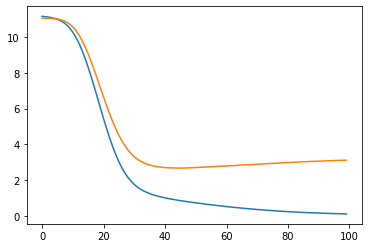

In [12]:
#check the result as a graph 
losses = pd.DataFrame(history.history)
plt.plot(losses)

In [13]:
#evaluate the data
model.evaluate([test.Place_Id, test.User_Id], test.Place_Ratings)

18/18 [==============================] - 0s 4ms/step - loss: 3.1260


3.126024007797241

In [14]:
#save the model
model.save('model.h5')

In [15]:
#convert the model to tensorflowjs
!tensorflowjs_converter --input_format=keras ./model.h5 ./tfjs_model

In [16]:
#create a model as a pickle 
pickle.dump(model,open("model.pkl", 'wb'))

INFO:tensorflow:Assets written to: ram://28417549-2799-456e-9f96-0718c54cc313/assets


In [17]:
#try to get the recomendation result
def get_recommendations(User_Id, Place, model):
  places = Place.copy()
  user_ids = np.array([User_Id] * len(places))
  results = model([places.Place_Id.values, user_ids]).numpy().reshape(-1)

  places['predicted_rating'] = pd.Series(results)
  places = places.sort_values('predicted_rating', ascending=False)

  print(f'Recommendations for user {User_Id}')
  return places

get_recommendations(2, Place, model)

Recommendations for user 2


,Place_Id,Place_Name,Description,Category,City,Price,Rating,Lat,Long,predicted_rating
77,78,Hiking Bocah,a variety of outdoor activities with a wide ch...,Amusement Park,Bogor,35000,4.3,-6.633071,106.837703,5.093870
1,2,Curug Love,This waterfall has a water flow that resembles...,Natural,Bogor,10000,4.6,-7.214250,107.030780,4.698093
111,112,Dulang Restourant,Explore all the local wisdom of Sundanese cult...,Foods,Bogor,15000,4.2,-6.688041,106.958518,4.301346
90,91,Taman Bunga Nusantara,an agro-tourism area that was created in 1992....,Amusement Park,Bogor,25000,4.4,-6.727507,107.079453,4.121244
27,28,Taman Wisata Matahari,have fun while getting acquainted with the bea...,Amusement Park,Bogor,60000,4.4,-6.656141,106.916704,4.088230
...,...,...,...,...,...,...,...,...,...,...
113,114,The Lake House,A place to eat surrounded by a pond in the mid...,Foods,Bogor,30000,4.6,-6.701882,106.948311,1.361300
107,108,Pasir Angin Pas,a beautiful place to eat that serves a variety...,Foods,Bogor,62000,4.4,-6.645092,106.866781,1.318478
95,96,Damar Langit,a hangout place surrounded by beautiful views ...,Foods,Bogor,0,4.6,-6.671361,106.953943,1.237632
25,26,Ski Tajur Katulampa,This place is good place to family vacation. T...,Shopping,Bogor,0,4.3,-6.622126,106.821334,1.152557
